# SF Salinity KOs, LASSO CV to predict methane v0.4

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib

import warnings
warnings.filterwarnings('ignore')

import sklearn as sk

%matplotlib inline


sns.set_style("white")
sns.set_style("ticks")

In [2]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler


In [3]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn import metrics

In [4]:
from sklearn.linear_model import RandomizedLasso

# Input data: Environment, Genes, Ontology

## Import Environment data:

In [5]:
# Import and clean environment data
# IMPROVED LOG DATA
Sal_meta = pd.read_csv('SF_sal_metaLOG_FIX2.txt', sep='\t', index_col=0)
Sal_meta['Salinity'] =  Sal_meta['Salinity.x']                                 #Sal_meta.columns # Sal_meta.head(10) # Sal_meta.EWcoastGroup.unique()

#### Make Environment Subsets

In [6]:
###  LOW Salinity sites                                       # Sal_meta.SALTgroup.unique()
FW = Sal_meta[Sal_meta['SALTgroup'].str.contains('FW')]         # Get subsets 
Oligo = Sal_meta[Sal_meta['SALTgroup'].str.contains('Oligo')]
# Meso = Sal_meta[Sal_meta['SALTgroup'].str.contains('Meso')]

# DELTA ONLY sites
Oligo_FW = (FW, Oligo)                                           # Make set list 
Oligo_FW_sites = pd.concat(Oligo_FW)                             # Concat SET
Oligo_FW_sites.sort_values(by = 'Index', axis=0, inplace=True)   # Sort on Site index        

### REF SITES ONLY 
Ref_sites_ONLY = Sal_meta[Sal_meta['EWcoastGroup'].str.contains('SF_Ref')]

### @@ choose OLIGO sites at own risk 

In [7]:
Sal_meta=Oligo_FW_sites

#### Select Env. Chem variables

In [8]:
## CUT Down Env. Data
env_chem_List = ['Salinity', 'Bulk_dens', 'H2O_FPS', 'CO2_mg_m2_h',                       # with log DATA, delete 'logCH4' now is logged, except for LIN vars
       'CO2_soilC_mg_g_d', 'CH4_ug_m2_h', 'CH4_CO2', 'CH4_soilC_ug_g_d', 'pH',            # Drop cations, corr w. Sal: 'Ca_pw', 'Sr_pw','Mg_pw', 'Na_pw', 'K_pw', 'Al_pw', 'Si_pw', 'Br_pw', 'F_pw', 'logCH4']
       'Cl', 'SO4', 'Corg_LOI', 'C', 'N', 'P', 'NO3_N', 'NH4_N', 'Olsen_P',               # Drop soil metals for now, half NA: 'Fe', 'Mn', 'Cu', 'Zn']
       'CN', 'CP', 'NP', 'NP_ext', 'NO3_NH4', 'C_g_m2', 'N_g_m2', 'P_g_m2',               # Drop redundant cols for PW: 'Salinity.x.1', 'CO2_mg_m2_h.1','CH4_ug_m2_h.1'
       'DOC_mg_L','Cl_pw', 'SO4_pw', 'NO2_pw', 'NO3_pw','NH3_pw',                         # Much more DELETED here, see earlier versions... # Sal_meta.columns # Env_chem.head()  
       'PO4_pw', 'Fe_pw', 'Mn_pw', 'Co_pw', 'Cu_pw', 'Zn_pw',
       'CH4_m2_lin', 'CO2_m2_lin', 'Salinity_lin'] 
              
# ABSTRACT Env_chem
Env_chem = Sal_meta[env_chem_List]  # Get columns
Env_chem.fillna(0, inplace = True)  # Fill NAs w 0, for porewater ND - careful with soil metals

## ReINDEX Env. chem, MUST BE by Sample
Sample= Sal_meta['Sample'] 
Env_chem = Env_chem.set_index(Sample,0) 
del Env_chem.index.name        

In [9]:
#Env_chem.Salinity.head()
# Env_chem.CH4_ug_m2_h.max()
#Env_chem.head()

## Import KO abundance table

In [10]:
### IMPORT CHANGED HERE TO MAKE KO A COLUMN, not index
# MG RAST updated KO counts (12/17)
Gene_abund = pd.read_csv('RAST_KO_ordered133_R2_F200_DESeq2_nrm.txt', sep='\t')#, index_col=0)      # RAST_KO_ordered133_R2_F200_DESeq2_nrm.txt

# Old FOAM data
#Gene_abund= pd.read_csv('FOAM_KO_ordered_F500_DESeq2_nrm.txt', sep='\t')#, index_col=0)                # FOAM

del Gene_abund.index.name   # Drop row index name before transpose
#Gene_abundT = Gene_abund.T  # TRANSPOSE, samples as rows for join with ENV#    #Gene_abundT.head() # Gene_abundT.head() # Gene_list = Gene_abundT.columns  # Get gene list (for later)  -- acting wonky, no methods could be use  # mgRAST_KO_de

In [11]:
#Gene_abundT.head()
# Gene_abund.head()

## Import ontology   

In [12]:
# Import CNPS, CH4, Ferment genes
gene_ontol = pd.read_csv('Ontology_KO_CNPSch4_Fm_whh0.txt', sep='\t', index_col=0)             # CNPSch4_Fm_KO

In [13]:
## ADD Abbrev. gene NAMES
Ont = gene_ontol         # Rename Ont shorter
gene_ontol['sm_name'] = (Ont['KO']+ " " + Ont['L3'] + " " + Ont['gene'].str[:4])
gene_ontol['mid_name'] = (Ont['KO']+ " " + Ont['L3'] + " ( " + Ont['gene'].str[:4] + " ) " + Ont['fxn'].str[:18])  # gene_ontol.head()

In [14]:
### Import Gene colors
gene_colors = pd.read_csv('Ontol_KO_L2_Color_KEY_whh0.txt', sep='\t', index_col=0)         # gene_colors = gene_colors.iloc[:,4:6]                                  # why not keep it all and drop later?        # get L3 colors and cats    # gene_colors

#### Merge colors, Ontol
gene_ontol_colors = pd.merge(gene_ontol, gene_colors, on = 'L2', how='inner')  # Here changed to L2   # gene_colors.head() #gene_ontol_colors

In [15]:
#gene_ontol_colors.head()

#### Subset ontology

In [16]:
### Get gene cycle subsets
gene_ontol_colors.head()
gene_ontol_colors.L1.unique()

Carbon = gene_ontol_colors[gene_ontol_colors['L1'].str.contains('Carbon')]             # L1 = Carbon 
Nitrogen = gene_ontol_colors[gene_ontol_colors['L1'].str.contains('Nitrogen')]         # L1 = Nitrogen
Phosphorus = gene_ontol_colors[gene_ontol_colors['L1'].str.contains('Phosphorus')]     # L1 = Phosphorus
Sulfur = gene_ontol_colors[gene_ontol_colors['L1'].str.contains('Sulfur')]             # L1 = Sulfur
CH4_cycling = gene_ontol_colors[gene_ontol_colors['L1'].str.contains('CH4_cycling')]   # L1 = CH4 
Fermentation = gene_ontol_colors[gene_ontol_colors['L1'].str.contains('Fermentation')] # L1 = Fermentaiton

NPS_CH4_LIST = [Nitrogen, Phosphorus, Sulfur, CH4_cycling]
#CNPS_CH4_LIST = [Nitrogen, Phosphorus, Sulfur, CH4_cycling]
# NPS_CH4 = pd.concat([NPS_CH4_LIST], 0) 

NPS_CH4 = pd.concat([Nitrogen, Phosphorus, Sulfur, CH4_cycling], 0)
CNPS_CH4 = pd.concat([Carbon, Nitrogen, Phosphorus, Sulfur, CH4_cycling], 0) 

In [17]:
# Choose subset - own risk
gene_ontol_colors = CNPS_CH4
#gene_ontol_colors

# Get only CNPS_CH4 gene abundances for lasso

In [18]:
 # Get only KO abundance for genes in CNPS ontology
CH4nps_KOs = pd.DataFrame(gene_ontol_colors['KO'])                           # Get only KOs from ontology
CH4nps_KOabund = pd.merge(CH4nps_KOs, Gene_abund, on='KO', how='inner')      # merge CNPS KO vector with KO abundance 
CH4nps_KOabund = CH4nps_KOabund.set_index('KO')                              # Set index as KO before transpose

CH4nps_KOabund_T = CH4nps_KOabund.T                                          # Transpose
CH4nps_KOabund_T['Sample'] = CH4nps_KOabund_T.index                          # Get sample col from 
CH4nps_KOabund_T.head()

KO                  K00847  K00012  K12447  K06859  K01835  K01835  K01835  \
Sandmound_TuleA_D1  10.947  13.212  3.1545  6.6914  12.767  12.767  12.767   
Sandmound_TuleA_D2  10.815  13.045  3.3375  7.1481  12.571  12.571  12.571   
Sandmound_TuleB_D1  10.868  13.239  3.0693  6.9424  12.801  12.801  12.801   
Sandmound_TuleB_D2  10.911  12.997  3.4680  7.2563  12.623  12.623  12.623   
Sandmound_TuleC_D1  10.841  13.195  3.8750  6.8160  12.668  12.668  12.668   

KO                  K01810  K00846  K04041         ...          K00582  \
Sandmound_TuleA_D1  13.056  4.5049  6.7433         ...          3.4160   
Sandmound_TuleA_D2  12.894  4.6485  7.1273         ...          3.7532   
Sandmound_TuleB_D1  13.032  5.0100  6.7690         ...          2.5844   
Sandmound_TuleB_D2  12.845  5.1443  6.6869         ...          3.3145   
Sandmound_TuleC_D1  12.996  4.7192  6.9888         ...          2.9406   

KO                  K00583  K00584  K00399  K00401  K00402  K03388  K03389  \
Sandmound_TuleA_D1  3.5268  6.0655  5.2508  5.0656  5.0656  13.440  10.799   
Sandmound_TuleA_D2  3.3375  6.1691  5.2638  4.6485  4.3133  13.363  10.888   
Sandmound_TuleB_D1  3.3865  6.0712  4.9700  5.3885  4.6521  13.485  10.753   
Sandmound_TuleB_D2  3.3145  6.2777  5.1840  4.9731  4.5513  13.519  10.843   
Sandmound_TuleC_D1  2.6417  5.0259  4.1627  5.1572  4.5361  13.018  10.432   

KO                  K03390              Sample  
Sandmound_TuleA_D1  9.3264  Sandmound_TuleA_D1  
Sandmound_TuleA_D2  9.4967  Sandmound_TuleA_D2  
Sandmound_TuleB_D1  9.3174  Sandmound_TuleB_D1  
Sandmound_TuleB_D2  9.4227  Sandmound_TuleB_D2  
Sandmound_TuleC_D1  9.1730  Sandmound_TuleC_D1  

[5 rows x 257 columns]

# Merge with ENV variable of interest

In [19]:
# Env_chem.head()

In [20]:
env_var = 'CH4_ug_m2_h'                                                  # abstraction ahead of function
env_var_df = pd.DataFrame(Env_chem[env_var])                                 # make standalone DF
env_var_df['Sample'] = env_var_df.index                                  # get sample name from index
env_var_df.shape            

(74, 2)

In [21]:
envVar_KOabundO = pd.merge(env_var_df, CH4nps_KOabund_T, on='Sample')    # Merge Env var with KO abundance by Samp.
envVar_KOabundO = envVar_KOabundO.set_index('Sample')
#envVar_KOabundO.head()

## Define and scale variables for ML 

In [22]:
X = envVar_KOabundO.drop(env_var,1)
y = envVar_KOabundO[env_var]

In [23]:
# Scale y and look at distribution  -- shouldn't be necessary as y is already log transformed?
robSc = RobustScaler()
#y_scaled = robSc.fit_transform(y)
# = robSc(Y)

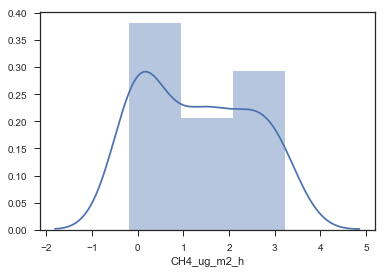

In [24]:
sns.distplot(y)
#sns.distplot(y_scaled) #  -- neither look great, explore additional transforms later

### Partion the data into training set and testing set

In [25]:
# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 5)

print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (42, 256)
X_test : (18, 256)
y_train : (42,)
y_test : (18,)


In [26]:
# Standardize numerical features, not using Standard scaler but log2 DESeq2 counts should be relatively normal?
robSc = RobustScaler()

X_scaled = robSc.fit_transform(X)
X_trainS = robSc.fit_transform(X_train)
X_testS = robSc.fit_transform(X_test)

In [27]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = "neg_mean_squared_error", cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = "neg_mean_squared_error", cv = 10))
    return(rmse)

#def rmse_cv(model):
#    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
#    return(rmse)

# LASSO Regression

### No data witheld

In [28]:
# Lasso
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_scaled, y)
alpha = lasso.alpha_
print("Best alpha :", alpha)


Best alpha : 0.03


In [29]:
print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X_scaled, y)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())
y_train_las = lasso.predict(X_scaled)
#y_test_las = lasso.predict(X_testS)

Try again for more precision with alphas centered around 0.03
Best alpha : 0.0345
Lasso RMSE on Training set : 0.768842229998
Lasso RMSE on Test set : 0.554774381515


In [30]:
accuracy = metrics.r2_score(y, y_train_las)
print("R2=", accuracy)

R2= 0.883169835316


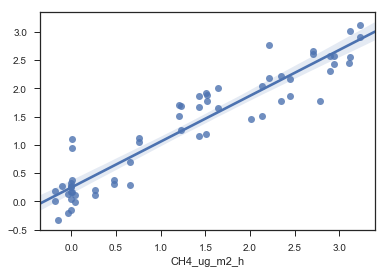

In [31]:
sns.regplot(x=y, y=y_train_las)

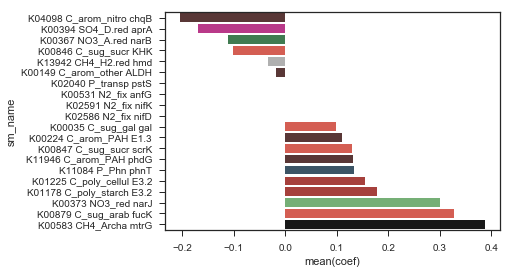

In [32]:
# Extract scaled coefficients
coef = pd.Series(lasso.coef_, index = X_train.columns)

# Get top 20 most important features
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

imp_coef = pd.DataFrame(imp_coef)                    # Make coef data frame
imp_coef.columns= ["coef"]                           # Name first column coef 
imp_coef['KO'] = imp_coef.index                      # add KOs
#imp_coef

coef_info = pd.merge(imp_coef, gene_ontol_colors)    # Merge with colors, ontology (incl sm. name)
pal = coef_info['color']                             # get colors

# Display coefficients, colored by gene category
sns.barplot(data=coef_info, y='sm_name', x='coef', palette=pal) #, orient='h')

### Using test train

In [33]:
# Lasso
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_trainS, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)


Best alpha : 0.06


In [34]:
print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X_trainS, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())
y_train_las = lasso.predict(X_trainS)
y_test_las = lasso.predict(X_testS)

Try again for more precision with alphas centered around 0.06
Best alpha : 0.069
Lasso RMSE on Training set : 0.770291813324
Lasso RMSE on Test set : 0.570674672747


In [35]:
from sklearn import metrics
accuracy = metrics.r2_score(y_train, y_train_las)
print("R2=", accuracy)

R2= 0.839455265755


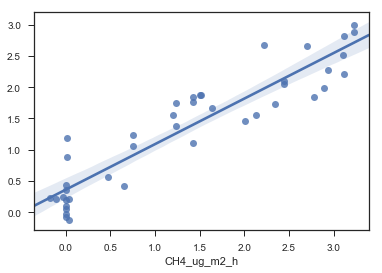

In [36]:
sns.regplot(x=y_train, y=y_train_las)

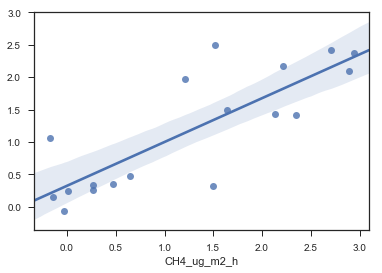

In [37]:
sns.regplot(x=y_test, y=y_test_las)

In [38]:
accuracy = metrics.r2_score(y_test, y_test_las)
print("R2=", accuracy)

R2= 0.66242513434


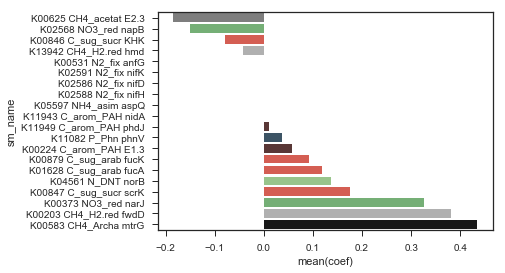

In [39]:
# Extract scaled coefficients
coef = pd.Series(lasso.coef_, index = X_train.columns)

# Get top 20 most important features
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

imp_coef = pd.DataFrame(imp_coef)                    # Make coef data frame
imp_coef.columns= ["coef"]                           # Name first column coef 
imp_coef['KO'] = imp_coef.index                      # add KOs
#imp_coef

coef_info = pd.merge(imp_coef, gene_ontol_colors)    # Merge with colors, ontology (incl sm. name)
pal = coef_info['color']                             # get colors

# Display coefficients, colored by gene category
sns.barplot(data=coef_info, y='sm_name', x='coef', palette=pal) #, orient='h')

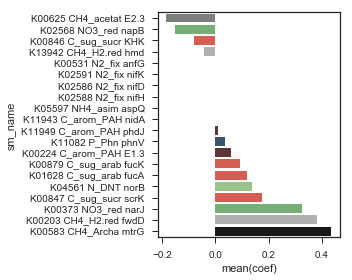

In [40]:
from matplotlib.backends.backend_pdf import PdfPages
#pp = PdfPages("test_Lasso_Genes_no_TT.pdf")                     # Initialize the pdf file
# PP = PdfPages("test_Lasso_GENES_SOILS.pdf")

fig = plt.figure(figsize=(5, 4))           # Define plot
sns.barplot(data=coef_info, y='sm_name', x='coef', palette=pal) #, orient='h')
fig.tight_layout()                    # Make tight layout
#pp.savefig()                            # Save the figure PDF created at top, else add file name .pdf  or  
#pp.close()   # Close the file

# Make ML model for soils only

In [41]:
# get soils input DF by re-arranging columns in soils DF

# here remove 'CH4_soilC_ug_g_d', 'CH4_CO2' 'CO2_m2_lin', 'CH4_m2_lin',

env_chem_CH4ml = ['Salinity', 'Bulk_dens', 'H2O_FPS', 'CO2_mg_m2_h',                       # with log DATA, delete 'logCH4' now is logged, except for LIN vars
       'CO2_soilC_mg_g_d', 'CH4_ug_m2_h', 'pH',            # Drop cations, corr w. Sal: 'Ca_pw', 'Sr_pw','Mg_pw', 'Na_pw', 'K_pw', 'Al_pw', 'Si_pw', 'Br_pw', 'F_pw', 'logCH4']
       'Cl', 'SO4', 'Corg_LOI', 'C', 'N', 'P', 'NO3_N', 'NH4_N', 'Olsen_P',               # Drop soil metals for now, half NA: 'Fe', 'Mn', 'Cu', 'Zn']
       'CN', 'CP', 'NP', 'NP_ext', 'NO3_NH4', 'C_g_m2', 'N_g_m2', 'P_g_m2',               # Drop redundant cols for PW: 'Salinity.x.1', 'CO2_mg_m2_h.1','CH4_ug_m2_h.1'
       'DOC_mg_L','Cl_pw', 'SO4_pw', 'NO2_pw', 'NO3_pw','NH3_pw',                         # Much more DELETED here, see earlier versions... # Sal_meta.columns # Env_chem.head()  
       'PO4_pw', 'Fe_pw', 'Mn_pw', 'Co_pw', 'Cu_pw', 'Zn_pw']
        #  'Salinity_lin'] 

In [42]:
Env_chem.head()

Salinity  Bulk_dens   H2O_FPS  CO2_mg_m2_h  \
Sandmound_CattailA_D1 -0.233021  -0.668042  1.947719     0.433113   
Sandmound_TuleA_D1    -0.226634  -0.576150  1.931627     0.170561   
Sandmound_TuleB_D1    -0.219956  -0.605605  1.902172     0.620485   
Sandmound_TuleC_D1    -0.246824  -0.619023  1.925604     0.246613   
Sandmound_ThreeSqA_D1 -0.179428  -0.647915  1.914517     0.596982   

                       CO2_soilC_mg_g_d  CH4_ug_m2_h   CH4_CO2  \
Sandmound_CattailA_D1         -1.904776     0.000000  0.000000   
Sandmound_TuleA_D1            -2.213225     0.650605 -0.519956   
Sandmound_TuleB_D1            -1.740932     0.000000  0.000000   
Sandmound_TuleC_D1            -2.131642    -0.033444 -1.280056   
Sandmound_ThreeSqA_D1         -1.756729    -0.147209 -1.744192   

                       CH4_soilC_ug_g_d        pH        Cl      ...       \
Sandmound_CattailA_D1          0.000000  0.795185  1.098298      ...        
Sandmound_TuleA_D1            -1.733181  0.789581  1.142702      ...        
Sandmound_TuleB_D1             0.000000  0.797268  1.149835      ...        
Sandmound_TuleC_D1            -2.411698  0.796574  1.116608      ...        
Sandmound_ThreeSqA_D1         -2.500920  0.802774  1.134177      ...        

                         NH3_pw    PO4_pw     Fe_pw     Mn_pw     Co_pw  \
Sandmound_CattailA_D1  1.025171  1.015674  2.627704  2.761387 -0.721246   
Sandmound_TuleA_D1     0.000000  0.000000  0.000000  0.000000  0.000000   
Sandmound_TuleB_D1     0.337526  0.188084  2.795477  3.070042 -0.408935   
Sandmound_TuleC_D1     0.709151  0.302331  3.579373  3.481973  0.315970   
Sandmound_ThreeSqA_D1  0.453777 -0.123782  2.505299  2.094017 -0.619789   

                          Cu_pw  Zn_pw  CH4_m2_lin  CO2_m2_lin  Salinity_lin  
Sandmound_CattailA_D1  0.240549    0.0   -0.254840    2.710899      0.584762  
Sandmound_TuleA_D1     0.000000    0.0    4.473064    1.481020      0.593425  
Sandmound_TuleB_D1     0.130334    0.0   -0.282940    4.173351      0.602621  
Sandmound_TuleC_D1     0.678518    0.0    0.925884    1.764464      0.566468  
Sandmound_ThreeSqA_D1  0.499687    0.0    0.712509    3.953506      0.661565  

[5 rows x 41 columns]

In [43]:
## Better: Def var, drop var, append var.

Env_chem = Env_chem[env_chem_CH4ml]

In [44]:
env_var = 'CH4_ug_m2_h'                                                  # abstraction ahead of function
env_var_df = pd.DataFrame(Env_chem[env_var])                                 # make standalone DF

env_chem_no_var = Env_chem.drop(env_var,1)
# env_chem_no_var.columns

chem_ML = env_var_df.join(env_chem_no_var)
chem_ML.head()
env_var_df['Sample'] = env_var_df.index                                  # get sample name from index

In [45]:
# Soils, genes model

## LASSO method

### Split x and y data

In [46]:
X = chem_ML.drop(env_var,1)
y = chem_ML[env_var]

### Split test train

In [47]:
# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (51, 35)
X_test : (23, 35)
y_train : (51,)
y_test : (23,)


### Scale numeric feats

In [48]:
# Standardize numerical features, not using Standard scaler but log2 DESeq2 counts should be relatively normal?
robSc = RobustScaler()

X_scaled = robSc.fit_transform(X)
X_trainS = robSc.fit_transform(X_train)
X_testS = robSc.fit_transform(X_test)

### LASSO MODEL

In [49]:
# Lasso

# Parameter tuning
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_scaled, y)
alpha = lasso.alpha_
print("Best alpha :", alpha)
# print("Try again for more precision with alphas centered around " + str(alpha))


# Run with greater precision 
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X_trainS, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())
y_train_las = lasso.predict(X_trainS)
y_test_las = lasso.predict(X_testS)

Best alpha : 0.006
Best alpha : 0.0084
Lasso RMSE on Training set : 0.51890154194
Lasso RMSE on Test set : 0.548734948792


### Plot fits 

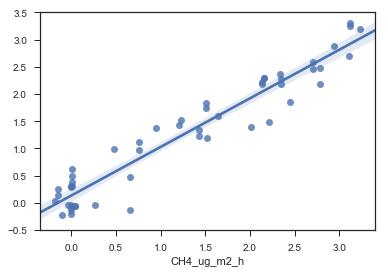

In [50]:
sns.regplot(x=y_train, y=y_train_las)

In [51]:
accuracy = metrics.r2_score(y_train, y_train_las)
print("R2=", accuracy)

R2= 0.920829257888


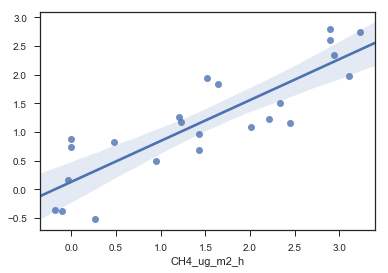

In [52]:
sns.regplot(x=y_test, y=y_test_las)

In [53]:
accuracy = metrics.r2_score(y_test, y_test_las)
print("R2=", accuracy)

R2= 0.67139552454


### Plot scaled coeffs

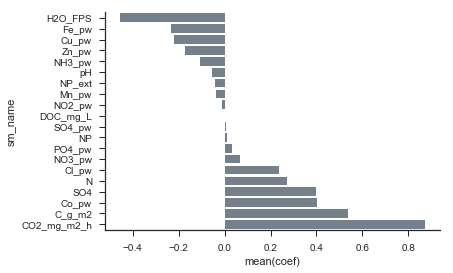

In [54]:
# Extract scaled coefficients
coef = pd.Series(lasso.coef_, index = X_train.columns)

# Get top 20 most important features
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

imp_coef = pd.DataFrame(imp_coef)                    # Make coef data frame
imp_coef.columns= ["coef"]                           # Name first column coef 
imp_coef['var'] = imp_coef.index                      # add KOs
#imp_coef

imp_coef['KO'] = imp_coef.index                      # add KOs
coef_info = pd.merge(imp_coef, gene_ontol_colors, how='left')    # Merge with colors, ontology (incl sm. name)
#pal = coef_info['color']                             # get colors

# Display coefficients, colored by gene category

sns.barplot(data=imp_coef, y='var', x='coef', color="slategrey")#, palette=pal) #, orient='h')
sns.despine()
#coef
# imp_coef

# To merge colors including genes / env
imp_coef['KO'] = imp_coef.index                      # add KOs

coef_info = pd.merge(imp_coef, gene_ontol_colors, how='left')            # Merge with colors, ontology (incl sm. name)
coef_info['sm_name'] = coef_info['sm_name'].fillna(coef_info['var'])     # fill missing from genes
coef_info['color'] = coef_info['color'].fillna('#708090')                # fill missing colors, here slate grey
pal = coef_info['color']                             # get colors

sns.barplot(data=coef_info, y='sm_name', x='coef', palette=pal) #, orient='h')


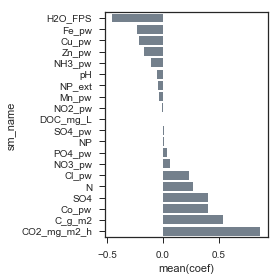

In [55]:
from matplotlib.backends.backend_pdf import PdfPages
#pp = PdfPages("test_Lasso_SOILS_all_sites.pdf")                     # Initialize the pdf file
# PP = PdfPages("test_Lasso_GENES_SOILS.pdf")

fig = plt.figure(figsize=(4, 4))           # Define plot
sns.barplot(data=coef_info, y='sm_name', x='coef', palette=pal) #, orient='h')
fig.tight_layout()                    # Make tight layout
#pp.savefig()                            # Save the figure PDF created at top, else add file name .pdf  or  
#pp.close()   # Close the file

### Get crazy, combine soils with genes --sloppy approach 

In [56]:
chem_ML['Sample'] = chem_ML.index
chem_genes = pd.merge(chem_ML, CH4nps_KOabund_T, on='Sample')
chem_genes = chem_genes.set_index('Sample')
chem_genes.head()
#chem_mL.head()
#chem_ML = chem_mL

CH4_ug_m2_h  Salinity  Bulk_dens   H2O_FPS  \
Sample                                                              
Sandmound_TuleA_D1        0.650605 -0.226634  -0.576150  1.931627   
Sandmound_TuleB_D1        0.000000 -0.219956  -0.605605  1.902172   
Sandmound_TuleC_D1       -0.033444 -0.246824  -0.619023  1.925604   
Sandmound_ThreeSqB_D1    -0.179321 -0.233021  -0.619023  1.925604   
Sandmound_ThreeSqC_D1     0.000000 -0.199671  -0.655601  1.906830   

                       CO2_mg_m2_h  CO2_soilC_mg_g_d        pH        Cl  \
Sample                                                                     
Sandmound_TuleA_D1        0.170561         -2.213225  0.789581  1.142702   
Sandmound_TuleB_D1        0.620485         -1.740932  0.797268  1.149835   
Sandmound_TuleC_D1        0.246613         -2.131642  0.796574  1.116608   
Sandmound_ThreeSqB_D1     0.422326         -1.944022  0.795880  1.209515   
Sandmound_ThreeSqC_D1     0.701456         -1.656043  0.808886  1.138618   

                            SO4  Corg_LOI   ...    K00581  K00582  K00583  \
Sample                                      ...                             
Sandmound_TuleA_D1     1.713491  1.164055   ...    5.3621  3.4160  3.5268   
Sandmound_TuleB_D1     1.599883  1.171141   ...    5.0868  2.5844  3.3865   
Sandmound_TuleC_D1     1.598791  1.201397   ...    4.0737  2.9406  2.6417   
Sandmound_ThreeSqB_D1  1.914343  1.189490   ...    3.3094  2.9138  3.3094   
Sandmound_ThreeSqC_D1  1.750508  1.217221   ...    2.6625  2.6625  2.6625   

                       K00584  K00399  K00401  K00402  K03388   K03389  K03390  
Sample                                                                          
Sandmound_TuleA_D1     6.0655  5.2508  5.0656  5.0656  13.440  10.7990  9.3264  
Sandmound_TuleB_D1     6.0712  4.9700  5.3885  4.6521  13.485  10.7530  9.3174  
Sandmound_TuleC_D1     5.0259  4.1627  5.1572  4.5361  13.018  10.4320  9.1730  
Sandmound_ThreeSqB_D1  4.7695  3.5973  4.8208  4.0243  11.708   9.9628  8.7866  
Sandmound_ThreeSqC_D1  4.3809  4.0288  4.3012  3.8093  11.643  10.0210  8.9589  

[5 rows x 292 columns]

## LASSO method

### Split x and y data

In [57]:
X = chem_genes.drop(env_var,1)
y = chem_genes[env_var]

### Split test train

In [58]:
# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (42, 291)
X_test : (18, 291)
y_train : (42,)
y_test : (18,)


### Scale numeric feats

In [59]:
# Standardize numerical features, not using Standard scaler but log2 DESeq2 counts should be relatively normal?
robSc = RobustScaler()

X_scaled = robSc.fit_transform(X)
X_trainS = robSc.fit_transform(X_train)
X_testS = robSc.fit_transform(X_test)

### LASSO MODEL

In [60]:
# Lasso

# Parameter tuning
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_trainS, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)
# print("Try again for more precision with alphas centered around " + str(alpha))


# Run with greater precision 
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X_trainS, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())
y_train_las = lasso.predict(X_trainS)
y_test_las = lasso.predict(X_testS)

Best alpha : 0.03
Best alpha : 0.0285
Lasso RMSE on Training set : 0.624271266149
Lasso RMSE on Test set : 0.535812278425


## Randomized Lasso

### Extract random Lasso

### Plot fits 

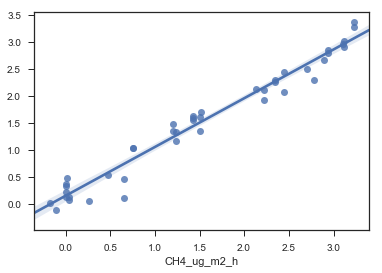

In [61]:
sns.regplot(x=y_train, y=y_train_las)

In [62]:
accuracy = metrics.r2_score(y_train, y_train_las)
print("R2=", accuracy)

R2= 0.961208239301


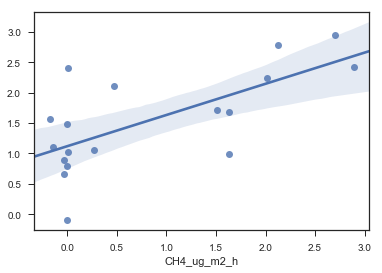

In [63]:
sns.regplot(x=y_test, y=y_test_las)

In [64]:
accuracy = metrics.r2_score(y_test, y_test_las)
print("R2=", accuracy)

R2= -0.0075811645855


### Plot scaled coeffs

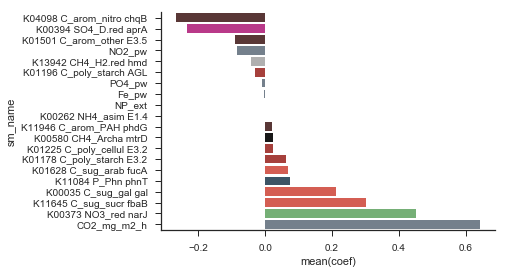

In [65]:
# Extract scaled coefficients
coef = pd.Series(lasso.coef_, index = X_train.columns)

# Get top 20 most important features
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

imp_coef = pd.DataFrame(imp_coef)                    # Make coef data frame
imp_coef.columns= ["coef"]                           # Name first column coef 
imp_coef['var'] = imp_coef.index                      # add KOs
#imp_coef

imp_coef['KO'] = imp_coef.index                      # add KOs
coef_info = pd.merge(imp_coef, gene_ontol_colors, how='left')    # Merge with colors, ontology (incl sm. name)
#pal = coef_info['color']                             # get colors

# Display coefficients, colored by gene category

sns.barplot(data=imp_coef, y='var', x='coef', color="slategrey")#, palette=pal) #, orient='h')
sns.despine()
#coef
# imp_coef

# To merge colors including genes / env
imp_coef['KO'] = imp_coef.index                      # add KOs

coef_info = pd.merge(imp_coef, gene_ontol_colors, how='left')            # Merge with colors, ontology (incl sm. name)
coef_info['sm_name'] = coef_info['sm_name'].fillna(coef_info['var'])     # fill missing from genes
coef_info['color'] = coef_info['color'].fillna('#708090')                # fill missing colors, here slate grey
pal = coef_info['color']                             # get colors

sns.barplot(data=coef_info, y='sm_name', x='coef', palette=pal) #, orient='h')


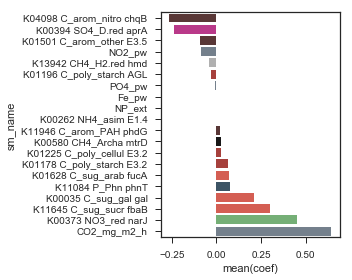

In [66]:
from matplotlib.backends.backend_pdf import PdfPages
#pp = PdfPages("test_Lasso_SOILS_Genes_all_sites.pdf")                     # Initialize the pdf file
# PP = PdfPages("test_Lasso_GENES_SOILS.pdf")

fig = plt.figure(figsize=(5, 4))           # Define plot
sns.barplot(data=coef_info, y='sm_name', x='coef', palette=pal) #, orient='h')
fig.tight_layout()                    # Make tight layout
#pp.savefig()                            # Save the figure PDF created at top, else add file name .pdf  or  
#pp.close()   # Close the file

## Randomized Lasso

In [67]:
# Lasso

# Parameter tuning
#lasso = RandomizedLasso(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
#                          0.3, 0.6, 1], 
#                max_iter = 50000, cv = 10)
#lasso.fit(X_trainS, y_train)
#alpha = lasso.alpha_
#print("Best alpha :", alpha)
# print("Try again for more precision with alphas centered around " + str(alpha))


# Run with greater precision 
lasso = RandomizedLasso()
#lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
#                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
#                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
#                          alpha * 1.4], 
#                max_iter = 50000, cv = 10)
lasso.fit(X_trainS, y_train)
#alpha = lasso.alpha_
#print("Best alpha :", alpha)

#print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
#print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())
#y_train_las = lasso.predict(X_trainS)
#y_test_las = lasso.predict(X_testS)

lasso
#lasso.scores_

RandomizedLasso(alpha='aic', eps=2.2204460492503131e-16, fit_intercept=True,
        max_iter=500, memory=Memory(cachedir=None), n_jobs=1,
        n_resampling=200, normalize=True, pre_dispatch='3*n_jobs',
        precompute='auto', random_state=None, sample_fraction=0.75,
        scaling=0.5, selection_threshold=0.25, verbose=False)

## Extract random lasso

In [68]:
#env_var_df

# Import 16S guilds

### Import guild counts

In [69]:
Guild_counts = pd.read_csv('OTU_Guild_abundT_counts.txt', sep='\t')#, index_col=0)      # RAST_KO_ordered133_R2_F200_DESeq2_nrm.txt

In [70]:
# Log2 n+1 transform data
Guild_counts2 = Guild_counts.replace(0,2)                     # For log n+1, replace 0 with 2
Guild_countsLog2 = np.log2(Guild_counts2)                     # Get log2 data 
Guild_countsLog2 = Guild_countsLog2.replace(1,0)                  # Make 0 again 0

Guild_countsLog2.head()

CH4_H2    CH4_ac      MOB_I  MOB_II    MOB_IIa  \
Sandmound_TuleA_D1  10.791848  8.213227  13.546500     0.0  13.262216   
Sandmound_TuleA_D2  11.116336  9.157559  13.414017     0.0  13.498663   
Sandmound_TuleB_D1   9.804864  0.000000  13.892327     0.0  11.389827   
Sandmound_TuleB_D2  11.068043  8.681020  14.052042     0.0  13.626238   
Sandmound_TuleC_D1  10.116270  6.883610  12.981642     0.0  13.071457   

                         MeOB        AOA       AOB        NOB      Anamx  \
Sandmound_TuleA_D1  12.616351  14.307374  0.000000  15.440273   6.872190   
Sandmound_TuleA_D2  12.239033  13.961281  4.007812  16.065127   6.592774   
Sandmound_TuleB_D1  11.389827  13.612219  0.000000  15.052792  11.389827   
Sandmound_TuleB_D2  12.878425  14.229693  0.000000  16.268292   6.980580   
Sandmound_TuleC_D1  12.187390  14.386640  0.000000  15.452706   7.468572   

                         SOxB    SRB_syn        SRB       FeOB       FeRB  \
Sandmound_TuleA_D1  11.322852  15.959300  14.433924  10.798190  12.284972   
Sandmound_TuleA_D2  11.850162  16.358337  15.680679  12.144803  12.124156   
Sandmound_TuleB_D1  12.974789  16.052792  17.062252  12.389827  13.264296   
Sandmound_TuleB_D2  12.468420  16.685996  16.064724  12.687939  12.920159   
Sandmound_TuleC_D1  10.837806  15.857451  14.232338  10.627771  12.150396   

                    Methanogen  Methanotroph  Methanogen_Troph   AOA_NOB  \
Sandmound_TuleA_D1   11.015148     14.411349         -3.396201 -1.132899   
Sandmound_TuleA_D2   11.446604     14.456960         -3.010357 -2.103846   
Sandmound_TuleB_D1    9.804864     14.126792         -4.321928 -1.440573   
Sandmound_TuleB_D2   11.320430     14.854793         -3.534363 -2.038599   
Sandmound_TuleC_D1   10.262121     14.027248         -3.765127 -1.066065   

                      AO_NOB  
Sandmound_TuleA_D1 -1.132899  
Sandmound_TuleA_D2 -2.102392  
Sandmound_TuleB_D1 -1.440573  
Sandmound_TuleB_D2 -2.038599  
Sandmound_TuleC_D1 -1.066065

In [71]:
# To Filter only delta samples, or other
Guild_countsLog2["Sample"] = Guild_countsLog2.index           # Get sample column from index
# Guild_countsLog2

Guild_abund = pd.merge(env_var_df, Guild_countsLog2, on='Sample')    # Merge Env var with KO abundance by Samp.
Guild_abund = Guild_abund.set_index('Sample')
#env_var_df# 

Guild_abund= Guild_abund.iloc[:,0:18]                               # drops ratios
Guild_abund.head()

CH4_ug_m2_h     CH4_H2    CH4_ac      MOB_I    MOB_II  \
Sample                                                                         
Sandmound_CattailA_D1     0.000000  11.280585  8.535966  14.155054  2.981377   
Sandmound_TuleA_D1        0.650605  10.791848  8.213227  13.546500  0.000000   
Sandmound_TuleB_D1        0.000000   9.804864  0.000000  13.892327  0.000000   
Sandmound_TuleC_D1       -0.033444  10.116270  6.883610  12.981642  0.000000   
Sandmound_ThreeSqA_D1    -0.147209  10.480372  7.702764  11.672391  0.000000   

                         MOB_IIa       MeOB        AOA       AOB        NOB  \
Sample                                                                        
Sandmound_CattailA_D1  13.763556  13.166253  12.787121  2.981377  15.351792   
Sandmound_TuleA_D1     13.262216  12.616351  14.307374  0.000000  15.440273   
Sandmound_TuleB_D1     11.389827  11.389827  13.612219  0.000000  15.052792   
Sandmound_TuleC_D1     13.071457  12.187390  14.386640  0.000000  15.452706   
Sandmound_ThreeSqA_D1  13.171534  12.910360  13.962395  0.000000  15.155545   

                           Anamx       SOxB    SRB_syn        SRB       FeOB  \
Sample                                                                         
Sandmound_CattailA_D1   6.151302  12.352065  16.573250  15.594246  11.712696   
Sandmound_TuleA_D1      6.872190  11.322852  15.959300  14.433924  10.798190   
Sandmound_TuleB_D1     11.389827  12.974789  16.052792  17.062252  12.389827   
Sandmound_TuleC_D1      7.468572  10.837806  15.857451  14.232338  10.627771   
Sandmound_ThreeSqA_D1   6.769878  10.932499  15.803051  13.978445   9.753390   

                            FeRB  Methanogen  Methanotroph  
Sample                                                      
Sandmound_CattailA_D1  13.313414   11.481223     14.972899  
Sandmound_TuleA_D1     12.284972   11.015148     14.411349  
Sandmound_TuleB_D1     13.264296    9.804864     14.126792  
Sandmound_TuleC_D1     12.150396   10.262121     14.027248  
Sandmound_ThreeSqA_D1  12.721958   10.676769     13.608509

### Import guild taxa

In [88]:
Guild_CH4_tax = pd.read_csv('CH4_guildG_log2abund_wkey.txt', sep='\t')#, index_col=0)      # RAST_KO_ordered133_R2_F200_DESeq2_nrm.txt

drop_vars = ["Guild", "color", "G_index"]
Guild_CH4_tax = Guild_CH4_tax.drop(drop_vars, 1)
Guild_CH4_tax = Guild_CH4_tax.set_index("Genus")
Guild_CH4_taxT = Guild_CH4_tax.T
Guild_CH4_taxT["Sample"] = Guild_CH4_taxT.index 
Guild_CH4_taxa = pd.merge(env_var_df, Guild_CH4_taxT, on='Sample')
Guild_CH4_taxa = Guild_CH4_taxa.set_index('Sample')
Guild_CH4_taxa.head()

X = Guild_CH4_taxa.drop(env_var,1)
y = Guild_CH4_taxa[env_var]


In [89]:
# envVar_KOabundO.head()

## Define and scale variables for ML 

### @@ combine guilds and chem

## @@ combine guilds and genes

## @@ guilds, chem, genes

In [90]:
#Guild_chem_genes.select_dtypes(exclude = ["object"]).columns

### Partion the data into training set and testing set

In [91]:
# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (50, 22)
X_test : (22, 22)
y_train : (50,)
y_test : (22,)


In [92]:
# Standardize numerical features, not using Standard scaler but log2 DESeq2 counts should be relatively normal?
robSc = RobustScaler()

X_scaled = robSc.fit_transform(X)
X_trainS = robSc.fit_transform(X_train)
X_testS = robSc.fit_transform(X_test)

# LASSO Regression

In [93]:
# Lasso
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)


Best alpha : 0.01


In [94]:
print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())
y_train_las = lasso.predict(X_scaled)
y_test_las = lasso.predict(X_test)

Try again for more precision with alphas centered around 0.01
Best alpha : 0.0125
Lasso RMSE on Training set : 0.673530446379
Lasso RMSE on Test set : 0.728800051964


In [95]:
accuracy = metrics.r2_score(y, y_train_las)
print("R2=", accuracy)

R2= 0.323165975486


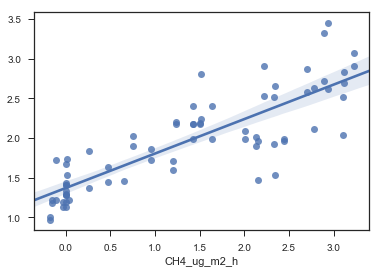

In [96]:
sns.regplot(x=y, y=y_train_las)

In [97]:
accuracy = metrics.r2_score(y_test, y_test_las)
print("R2=", accuracy)

R2= 0.566984221373


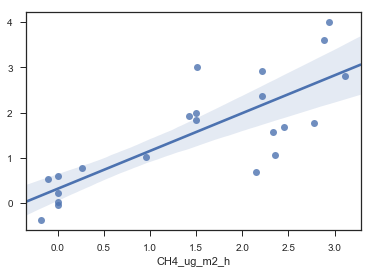

In [98]:
sns.regplot(x=y_test, y=y_test_las)

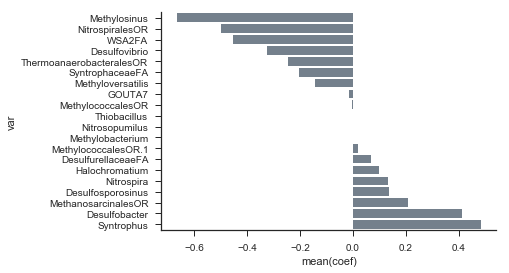

In [99]:
# Extract scaled coefficients
coef = pd.Series(lasso.coef_, index = X_train.columns)

# Get top 20 most important features
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

imp_coef = pd.DataFrame(imp_coef)                    # Make coef data frame
imp_coef.columns= ["coef"]                           # Name first column coef 
imp_coef['var'] = imp_coef.index                      # add KOs
imp_coef

sns.barplot(data=imp_coef, y='var', x='coef', color="slategrey")#, palette=pal) #, orient='h')
sns.despine()

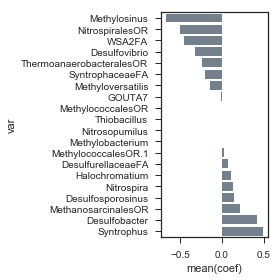

In [101]:
from matplotlib.backends.backend_pdf import PdfPages
#pp = PdfPages("test_Lasso_SOILS_all_sites.pdf")                     # Initialize the pdf file
#pp = PdfPages("Lasso_Guilds.pdf")
#pp = PdfPages("Lasso_CorrCH4_Guilds.pdf")
#pp = PdfPages("Lasso_Soils_Guilds.pdf")

fig = plt.figure(figsize=(4, 4))           # Define plot
sns.barplot(data=imp_coef, y='var', x='coef', color="slategrey")#, palette=pal) #, orient='h')

#sns.barplot(data=coef_info, y='sm_name', x='coef', palette=pal) #, orient='h')
fig.tight_layout()                    # Make tight layout
#pp.savefig()                            # Save the figure PDF created at top, else add file name .pdf  or  
#pp.close()   # Close the file